# This is a notebook that shows how to produce Grad-CAM visualizations for ALBEF

# 1. Set the paths for model checkpoint and configuration

In [1]:
model_path = '/home/beast/Desktop/Daniel/charan_anna/VLAT/Pretrain/checkpoint_00.pth'
bert_config_path = 'configs/config_bert.json'
use_cuda = True

# 2. Model defination

In [2]:
from functools import partial
from models.xbert import BertLMHeadModel, BertConfig, BertModel
from models.vit import VisionTransformer, interpolate_pos_embed
from transformers import ViTConfig, ViTModel
from transformers import  BertTokenizer
from models.xbert import BertForMaskedLM
import torch
import timm
import numpy as np
from torch import nn

/home/beast/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_size=768, num_heads=8):
        super(SelfAttention, self).__init__()
        self.mhatt = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)

    def forward(self, x, mask=None):
        attn_output, _ = self.mhatt(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        return x


class GuidedAttention(nn.Module):
    def __init__(self, hidden_size=768, num_heads=8):
        super(GuidedAttention, self).__init__()
        self.mhatt = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)

    def forward(self, x, y, x_mask=None, y_mask=None):
        # Cross-attention between x and y
        attn_output, _ = self.mhatt(x, y, y, attn_mask=x_mask)
        # print("attn_ouptut.shape",attn_output.shape)
        x = self.norm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        return x


class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size=768, num_heads=8, num_layers=6):
        super(EncoderDecoder, self).__init__()
        self.self_attention_layers = nn.ModuleList([SelfAttention(hidden_size, num_heads) for _ in range(num_layers)])
        self.guided_attention_layers = nn.ModuleList([GuidedAttention(hidden_size, num_heads) for _ in range(num_layers)])

    def forward(self, image_embeddings, text_embeddings, image_mask=None, text_mask=None):
        # Process image and text embeddings with self-attention
        for sa_layer in self.self_attention_layers:
            image_embeddings = sa_layer(image_embeddings, image_mask)
            text_embeddings = sa_layer(text_embeddings, text_mask)
        
        # Cross-attention (guided attention) between image and text
        for ga_layer in self.guided_attention_layers:
            image_embeddings = ga_layer(image_embeddings, text_embeddings, image_mask, text_mask)
            text_embeddings = ga_layer(text_embeddings, image_embeddings, text_mask, image_mask)
        
        return image_embeddings, text_embeddings


# class ImageEncoder(nn.Module):
#     def __init__(self, pretrained=False, image_size=224, output_dim=768):
#         super(ImageEncoder, self).__init__()
#         self.vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k') if pretrained else ViTModel(ViTConfig(image_size=image_size, patch_size=16, embed_dim=768, mlp_ratio=4, qkv_bias=True, layer_norm_eps=1e-6))
#         # self.vit_model = ViTModel(ViTConfig(image_size=image_size, patch_size=16, embed_dim=768, mlp_ratio=4, qkv_bias=True, layer_norm_eps=1e-6))
#     def forward(self, images):
#         outputs = self.vit_model(images)
#         return outputs.last_hidden_state[:, :-1, :]


class ImageEncoder(nn.Module):
    def __init__(self, pretrained=True, image_size=224, output_dim=768, init_deit=False):
        super(ImageEncoder, self).__init__()
        # self.vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k') if pretrained else ViTModel(ViTConfig(image_size=image_size, patch_size=16, embed_dim=768, mlp_ratio=4, qkv_bias=True, layer_norm_eps=1e-6))
        # self.vit_model = ViTModel(ViTConfig(image_size=image_size, patch_size=16, embed_dim=768, mlp_ratio=4, qkv_bias=True, layer_norm_eps=1e-6))
        self.vit_model = VisionTransformer(
            img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        if init_deit:
            checkpoint = torch.hub.load_state_dict_from_url(
                url="https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth",
                map_location="cpu", check_hash=True)
            state_dict = checkpoint["model"]
            pos_embed_reshaped = interpolate_pos_embed(state_dict['pos_embed'], self.vit_model)
            state_dict['pos_embed'] = pos_embed_reshaped
            msg = self.vit_model.load_state_dict(state_dict,strict=False) 
            print(msg)

    def forward(self, images):
        image_embeds = self.vit_model(images) 
        return image_embeds

class TextEncoder(nn.Module):
    def __init__(self, model_name='bert-base-uncased', output_dim=768):
        super(TextEncoder, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

        text_config_encoder = BertConfig(vocab_size=30522, fusion_layer=6,encoder_width=768, num_hidden_layers=12, num_attention_heads=12, hidden_size=768, layer_norm_eps=1e-12, max_position_embeddings=512, hidden_act="gelu", hidden_dropout_prob=0.2, initializer_range=0.02, intermediate_size=3072, attention_probs_dropout_prob=0.2)   
        self.bert = BertModel(config=text_config_encoder)

    def forward(self, text):
        outputs = self.bert(text['input_ids'], attention_mask=text['attention_mask'], return_dict = True, mode = 'text')
        return outputs.last_hidden_state

In [4]:
class VLAT(nn.Module):
    def __init__(self):
        super().__init__()

        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.encoder_decoder = EncoderDecoder()
        
        
        text_config_encoder = BertConfig(vocab_size=30522, fusion_layer=6,encoder_width=768, num_hidden_layers=12, num_attention_heads=12, hidden_size=768, layer_norm_eps=1e-12, max_position_embeddings=512, hidden_act="gelu", hidden_dropout_prob=0.2, initializer_range=0.02, intermediate_size=3072, attention_probs_dropout_prob=0.2)   
        self.text_encoder_1 = BertModel(config=text_config_encoder)
        
        
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") 
        
 
        self.itm_head = nn.Linear(768, 2) 

   

    def forward(self, image, questions):
   
        image_features = self.image_encoder(image) # (16. 3, 224, 224) -->  (batch_size, num_patches+1, hidden_dim) # (16, 197, 768) # 16*1,51,296*3
        image_atts = torch.ones(image_features.size()[:-1],dtype=torch.long)
        
        question_features = self.text_encoder(questions) #input_ids-->(16, sequence_length), (16, sequence_length,768) # (batch_size, sequence_length, hidden_dim), (16, 11, 768) #16*8448*3
        image_embeddings, text_embeddings = self.encoder_decoder(image_features, question_features) # need to Mask, with mask and without masking # mcan
        
       
        output = self.text_encoder_1(attention_mask = questions.attention_mask, 
                                        inputs_embeds = text_embeddings, 
                                        encoder_hidden_states = image_embeddings,
                                        encoder_attention_mask = image_atts,                             
                                        return_dict = True)
       

        vl_embeddings = output.last_hidden_state[:,0,:]
        vl_output = self.itm_head(vl_embeddings)            
        
        return vl_output

# 3. Text Preprocessing

In [5]:
import re

def pre_caption(caption,max_words=30):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])            
    return caption

# 4. Image Preprocessing and Postpressing

In [6]:
from PIL import Image

import cv2
import numpy as np
from torchvision import transforms
from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    
    attMap = skimage_transform.resize(attMap.numpy(), (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap


normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((384,384),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])     

/tmp/ipykernel_2966885/989219405.py:7: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.ndimage import filters
/home/beast/.local/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 5. Load model and tokenizer

In [7]:
model = VLAT()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
checkpoint = torch.load(model_path, map_location='cpu')              
msg = model.load_state_dict(checkpoint,strict=False)
model.eval()

VLAT(
  (image_encoder): ImageEncoder(
    (vit_model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): 

# 6. Load Image and Text

In [8]:
image_path = '/home/beast/Downloads/val2014/COCO_val2014_000000184613.jpg'
image_pil = Image.open(image_path).convert('RGB')   
image = transform(image_pil).unsqueeze(0)  

caption = 'A child holding a flowered umbrella and petting a yak'
text = pre_caption(caption)
text_input = tokenizer(text, return_tensors="pt")
use_cuda = False
if use_cuda:
    image = image.cuda()
    text_input = text_input.to(image.device)

# 7. Compute GradCAM

In [9]:
model.text_encoder_1.base_model.base_model.encoder.layer[8].crossattention.self.save_attention =True


In [10]:
vloutput = model(image, text_input)
loss = vloutput[:,1].sum()
print(loss)
# print(output)
model.zero_grad()
loss.backward()    

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)
    
    grads=model.text_encoder_1.base_model.base_model.encoder.layer[8].crossattention.self.get_attn_gradients()
    cams=model.text_encoder_1.base_model.base_model.encoder.layer[8].crossattention.self.get_attention_map()
    # print(cams.shape, grads.shape)
    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()

tensor(-0.2651, grad_fn=<SumBackward0>)


/tmp/ipykernel_2966885/989219405.py:17: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with R

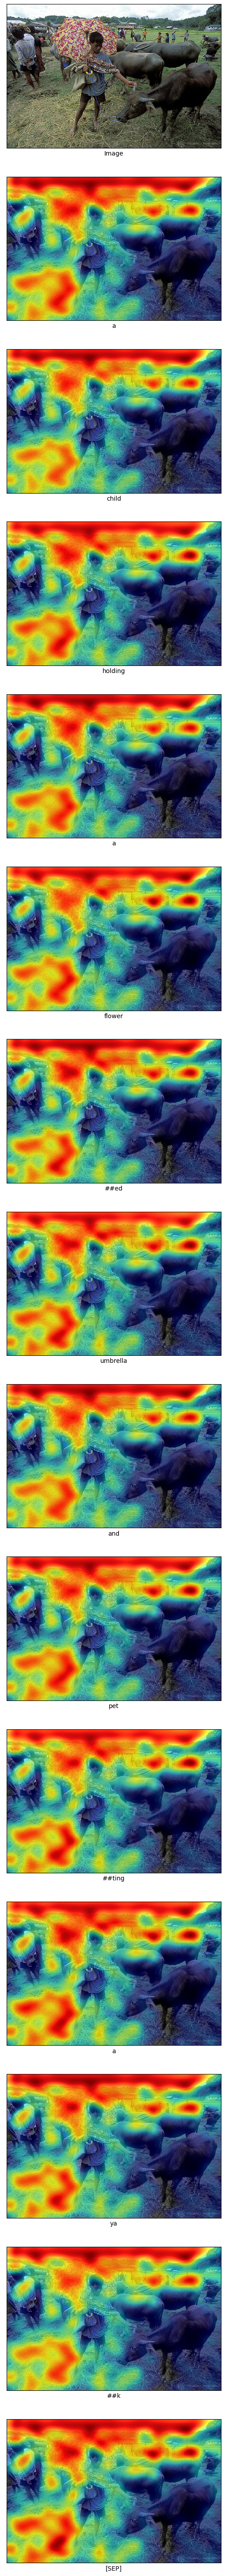

In [11]:
num_image = len(text_input.input_ids[0]) 
fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")
            
for i,token_id in enumerate(text_input.input_ids[0][1:]):
    word = tokenizer.decode([token_id])
    
    gradcam_image = getAttMap(rgb_image, gradcam[i+1])
    ax[i+1].imshow(gradcam_image)
    ax[i+1].set_yticks([])
    ax[i+1].set_xticks([])
    ax[i+1].set_xlabel(word)